# Identification vs Detection: Visualizing differences on simplex

In [1]:
import sys
import itertools
import collections
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import ternary

from utils.visualization import plot_pdf_triplex, plot_prob_triplex, reliability_plot, ECE_plot
from utils.ops import onehot_encode, detection_log_likelihood_ratios

In [2]:
%matplotlib inline

## Generate mesh of probabilities

In [3]:
indep_probs = np.array([np.array(tup) for tup in itertools.product(np.linspace(0, 1, num=100), repeat=2)])
indep_probs = indep_probs[np.where(np.sum(indep_probs, axis=1)<=1)]
probs = np.hstack((indep_probs, 1.-np.sum(indep_probs, axis=1, keepdims=True)))

target = onehot_encode(np.argmax(probs, axis=1))

## Compute the relative log-likelihoods

In [4]:
RLL = np.log(probs + 1e-7)
# Start asumming flat prior
priors = np.zeros(3) + 1./3

## Identification problem: 
Choose $t$ such that for any $i \neq t$ the resulting log-likelihood-ratio $\lambda^{t}_{i} = \lambda_{t} - \lambda_{i}$ is greater than the threshold: $\theta^{t}_{i} = -log(\pi_{t}) + log(\pi_{i})$, where $\{\lambda_i\}$ are the relative-log-likelihoods and $\{\pi_i\}$ is the prior probability distribution.

This corresponds to select the class with the highest posterior probability. Assuming a flat prior this is done by simply selecting the maximum over the classifier output.

*Note:*
The evaluated hypothesis are mutually exclusive, this is incompatible with the decision rule when 2 hypothesis have the same posterior probability and this is maximum. To handle this we take only the first encountered one.

**Naive approach:**
Start with the set of all possible classes as identified and check for every $t$ and $i$, whenever the condition $\lambda^{t}_{i} \geq \theta^{t}_{i}$ is not met we remove class $t$ from the set of identified classes.

In [5]:
identified = [set([0, 1, 2]) for _ in range(RLL.shape[0])]

for t in range(3):
    for i in range(3):
        if t==i:
            continue
        llr = RLL[:, t] - RLL[:, i]
        th = -np.log(priors[t]) + np.log(priors[i])
        for k in range(len(identified)):
            if llr[k] < th:
                identified[k].discard(t)
                
identified_naive = np.array([list(k)[0] for k in identified])

**Direct approach:** Having already computed the posterior probabilities we can select the class with the highest. Since the logarithm is a monotonically increasing function the analysis can be perform on the *log* domain.

In [6]:
posterior_RLL = RLL + np.log(priors)
identified = np.argmax(posterior_RLL, axis=1)

Check whether both methods agree:

In [7]:
print('Number of disagreements: {}'.format(np.sum(np.abs(identified - identified_naive))))

Number of disagreements: 0


## Detection problem:
The detection problem poses a harder constraint in order to recognize a given target, this is: that the posterior probability of the target is greater than the complementary hypothesis, i.e. greater than 0.5.

**Working with RLL:** We need to build the detection log-likelihood-ratio $\lambda^t_{\neg t}$, which depends on the prior probabilities.
$$
\lambda^t_{\neg t} = -log \sum_{i \neq t}\frac{\pi_i}{1-\pi_t}e^{-\lambda^{t}_{i}}
$$
And compare it with the decision threshold $\theta^t_{\neg t} = -log(\pi_t) + log(1 - \pi_t)$

In [8]:
detection_LLR = detection_log_likelihood_ratios(RLL, priors)

In [9]:
detected = np.zeros(RLL.shape[0]) - 1.

for t in range(3):
    th = -np.log(priors[t]) + np.log(1 - priors[t])
    detected[np.where(detection_LLR[:, t]>=th)] = t

In [10]:
print("Ratio of detected hypothesis: {:.3f}".format(np.sum(detected>=0)/detected.size))

Ratio of detected hypothesis: 0.757


**Working with probabilities:** Detecting one class can be seen as evaluating its posteorior probability and recognizing the hypothesis if this is equal or greater than 0.5:

In [11]:
posteriors = softmax(RLL, axis=1)*priors
# Normalie distribution
posteriors = posteriors/np.sum(posteriors, axis=1, keepdims=True)

In [12]:
detected_probs = np.zeros(RLL.shape[0]) - 1.

for t in range(3):
    detected_probs[np.where(posteriors[:, t]>=0.5)] = t

In [13]:
print("Ratio of detected hypothesis: {:.3f}".format(np.sum(detected_probs>=0)/detected_probs.size))

Ratio of detected hypothesis: 0.757


Check both methods are equivalent:

In [14]:
print('Number of disagreements: {}'.format(np.sum(np.abs(detected - detected_probs))))

Number of disagreements: 0.0


## Visualize differences:
### Ratio of recognized hypothesis:

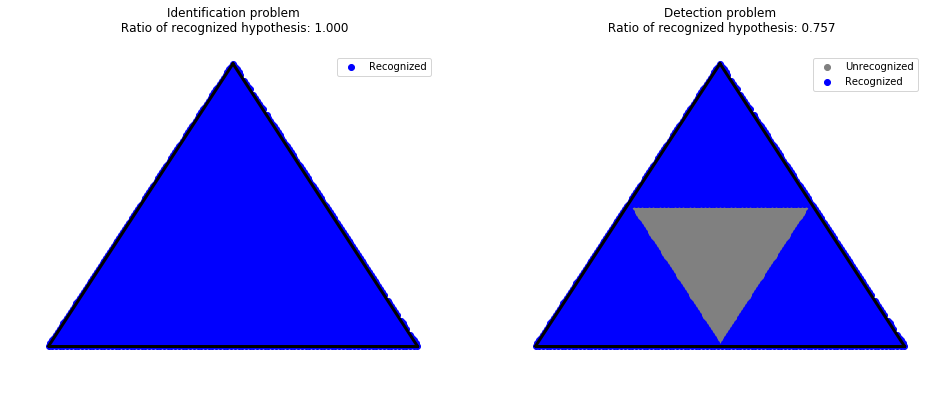

In [27]:
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 6))

# Identification problem
ax_arr[0].axis('off')
_, tax0 = ternary.figure(ax=ax_arr[0])

if any(identified<0):
    tax0.scatter(probs[np.where(identified<0)], color='0.5', label='Unrecognized')
tax0.scatter(probs[np.where(identified>=0)], color='b', label='Recognized')
tax0.legend()
tax0.set_title('Identification problem\n Ratio of recognized hypothesis: {:.3f}\n'.format(np.sum(identified>=0)/identified.size), fontsize=12)
tax0.boundary(linewidth=3.0)
ax_arr[0] = tax0


# Detection problem
ax_arr[1].axis('off')
_, tax1 = ternary.figure(ax=ax_arr[1])
if any(detected<0):
    tax1.scatter(probs[np.where(detected<0)], color='0.5', label='Unrecognized')
tax1.scatter(probs[np.where(detected>=0)], color='b', label='Recognized')
tax1.legend()
tax1.set_title('Detection problem\n Ratio of recognized hypothesis: {:.3f}\n'.format(np.sum(detected>=0)/detected.size), fontsize=12)
tax1.boundary(linewidth=3.0)
ax_arr[1] = tax1

plt.show();

### Recognized labels in each case:

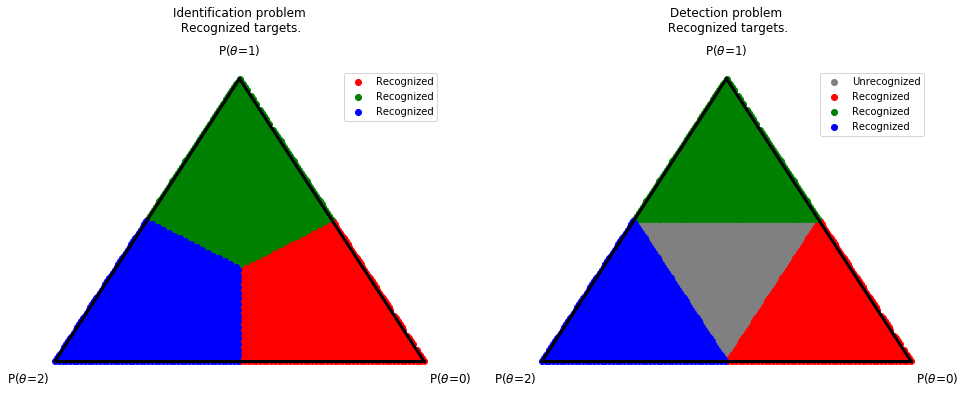

In [29]:
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 6))
colors = ['r', 'g', 'b']

# Identification problem
ax_arr[0].axis('off')
_, tax0 = ternary.figure(ax=ax_arr[0])

if any(identified<0):
    tax0.scatter(probs[np.where(identified<0)], color='0.5', label='Unrecognized')

for t in range(3):
    tax0.scatter(probs[np.where(identified==t)], color=colors[t], label='Recognized')

tax0.legend()
tax0.right_corner_label("P($\\theta$=0)", fontsize=12)
tax0.top_corner_label("P($\\theta$=1)", fontsize=12)
tax0.left_corner_label("P($\\theta$=2)", fontsize=12)
tax0.set_title('Identification problem\n Recognized targets.\n\n', fontsize=12)
tax0.boundary(linewidth=3.0)
ax_arr[0] = tax0


# Detection problem
ax_arr[1].axis('off')
_, tax1 = ternary.figure(ax=ax_arr[1])

if any(detected<0):
    tax1.scatter(probs[np.where(detected<0)], color='0.5', label='Unrecognized')

for t in range(3):
    tax1.scatter(probs[np.where(detected==t)], color=colors[t], label='Recognized')

tax1.legend()
tax1.right_corner_label("P($\\theta$=0)", fontsize=12)
tax1.top_corner_label("P($\\theta$=1)", fontsize=12)
tax1.left_corner_label("P($\\theta$=2)", fontsize=12)
tax1.set_title('Detection problem\n Recognized targets.\n\n', fontsize=12)
tax1.boundary(linewidth=3.0)
ax_arr[1] = tax1

plt.show();